## Fit the probit SOTA model of acquisition probabilities with MS flag disabled

Fit values here were computed 2017-May-22

In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
import tables
from scipy import stats

%matplotlib inline

### Final 2015 fit values

In [2]:
SOTA2015_FIT_ALL = [3.9438714542029976, 5.4601129927961134, 1.6582423213669775, 
                    -2.0646518576907495, 0.36414269305801689, -0.0075143036207362852, 
                    0.003740065500207244]


In [3]:
SOTA2015_FIT_NO_1P5 = [4.092016310373646, 6.5415918325159641, 1.8191919043258409, 
                       -2.2301709573082413, 0.30337711472920426, 0.10116735012955963, 
                       0.0043395964215468185]

In [4]:
SOTA2015_FIT_ONLY_1P5 = [4.786710417762472, 4.839392687262392, 1.8646719319052267, 
                         -1.4926740399312248, 0.76412972998935347, -0.20229644263097146, 
                         0.0016270748026844457]

### Final 2017 fit values

In [5]:
SOTA2017_FIT_NO_1P5 = [4.0538501953116741, 5.1264366287835923, 1.7189285794461362, # offsets
                       -2.2336697695626575, 0.41899916884144967, 0.11507943243652813, # scales
                       0.0038974199036680645]  # brighter than 8.5 mag

In [6]:
SOTA2017_FIT_ONLY_1P5 = [4.411152936402706, 6.9164655965293083, 4.3825409576699306,
                         -1.4663437225896943, 0.60465093328488229, -0.38990790420590932,
                         0.0017918677401650661]

## Fit code

In [7]:
with tables.openFile('/proj/sot/ska/data/acq_stats/acq_stats.h5', 'r') as h5:
    cols = h5.root.data.cols
    names = {'tstart': 'guide_tstart',
             'obsid': 'obsid',
             'obc_id': 'acqid',
             'warm_pix': 'n100_warm_frac',
             'mag': 'mag_aca',
             'known_bad': 'known_bad',
             'color': 'color1',
            'img_func': 'img_func', 
            'ion_rad': 'ion_rad',
            'sat_pix': 'sat_pix'}
    acqs = Table([getattr(cols, h5_name)[:] for h5_name in names.values()],
                 names=list(names.keys()))

    year_q0 = 1999.0 + 31. / 365.25  # Jan 31 approximately

In [8]:
acqs['year'] = Time(acqs['tstart'], format='cxcsec').decimalyear.astype('f4')
acqs['quarter'] = (np.trunc((acqs['year'] - year_q0) * 4)).astype('f4')
acqs['color_1p5'] = np.where(acqs['color'] == 1.5, 1, 0)

In [9]:
data_all = acqs.group_by('quarter')
data_all['mag10'] = data_all['mag'] - 10.0
data_all.sort('year')
ok = (data_all['year'] > 2007) & (data_all['mag'] > 6.0) & (data_all['mag'] < 11.0)
data_all = data_all[ok]
data_all = data_all.group_by('quarter')
data_mean = data_all.groups.aggregate(np.mean)

ok = np.ones(len(data_all), dtype=bool)
print('Filtering known bad obsids, start len = {}'.format(len(data_all)))
bad_obsids = [
    # Venus
    2411,2414,6395,7306,7307,7308,7309,7311,7312,7313,7314,7315,7317,7318,7406,583,
    7310,9741,9742,9743,9744,9745,9746,9747,9749,9752,9753,9748,7316,15292,16499,
    16500,16501,16503,16504,16505,16506,16502,
    ]
for badid in bad_obsids:
    ok = ok & (data_all['obsid'] != badid)
data_all = data_all[ok]
print('Filtering known bad obsids, end len = {}'.format(len(data_all)))

Filtering known bad obsids, start len = 126007
Filtering known bad obsids, end len = 125847


In [10]:
def p_fail(pars, m10, wp):
    """
    Acquisition probability model

    :param pars: 7 parameters (3 x offset, 3 x scale, p_fail for bright stars)
    :param m10: mag - 10
    :param wp: warm pixel fraction
    """
    scl0, scl1, scl2 = pars[0:3]
    off0, off1, off2 = pars[3:6]
    p_bright_fail = pars[6]

    scale = scl0 + scl1 * m10 + scl2 * m10**2
    offset = off0 + off1 * m10 + off2 * m10**2

    p_fail = offset + scale * wp
    p_fail = stats.norm.cdf(p_fail)  # probit transform
    p_fail[m10 < -1.5] = p_bright_fail  # For stars brighter than 8.5 mag use a constant

    return p_fail

def p_acq_fail(data=None):
    """
    Sherpa fit function wrapper to ensure proper use of data in fitting.
    """
    if data is None:
        data = data_all
        
    def sherpa_func(pars, x):
        m10 = data['mag10']
        wp = data['warm_pix']
        return p_fail(pars, m10, wp)

    return sherpa_func

In [11]:
def fit_sota_model(data_mask=None, ms_disabled=False):
    from sherpa import ui

    obc_id = data_all['obc_id']
    if ms_disabled:
        obc_id |= (data_all['img_func'] == 'star') & ~data_all['ion_rad'] & ~data_all['sat_pix']    
    data_all['fail'] = np.where(obc_id, 0.0, 1.0)

    data = data_all if data_mask is None else data_all[data_mask]

    data_id = 1
    ui.set_method('simplex')
    ui.set_stat('cash')
    ui.load_user_model(p_acq_fail(data), 'model')
    ui.add_user_pars('model', ['scl0', 'scl1', 'scl2', 'off0', 'off1', 'off2', 'p_bright_fail'])
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(data['year']), np.array(data['fail'], dtype=np.float))

    # Initial fit values from fit of all data
    start_vals = iter(SOTA2015_FIT_ALL)  # Offset
    fmod = ui.get_model_component('model')
    for name in ('scl', 'off'):
        for num in (0, 1, 2):
            comp_name = name + str(num)
            setattr(fmod, comp_name, start_vals.next())
            comp = getattr(fmod, comp_name)
            comp.min = -100000
            comp.max = 100000
            # ui.freeze(comp)
    
    fmod.p_bright_fail = 0.025
    fmod.p_bright_fail.min = 0.0
    fmod.p_bright_fail.max = 1.0
    # ui.freeze(fmod.p_bright_fail)
    
    ui.fit(data_id)
    # conf = ui.get_confidence_results()
    return ui.get_fit_results()

## Plotting and validation

In [12]:
def plot_fit_grouped(pars, group_col, group_bin, mask=None, log=False, colors='br', label=None):
    data = data_all if mask is None else data_all[mask]
    data['model'] = p_acq_fail(data)(pars, None)

    group = np.trunc(data[group_col] / group_bin)
    data = data.group_by(group)
    data_mean = data.groups.aggregate(np.mean)
    len_groups = np.diff(data.groups.indices)
    fail_sigmas = np.sqrt(data_mean['fail'] * len_groups) / len_groups
    
    plt.errorbar(data_mean[group_col], data_mean['fail'], yerr=fail_sigmas, fmt='.' + colors[0], label=label)
    plt.plot(data_mean[group_col], data_mean['model'], '-' + colors[1])
    if log:
        ax = plt.gca()
        ax.set_yscale('log')

In [13]:
def mag_filter(mag0, mag1):
    ok = (data_all['mag'] > mag0) & (data_all['mag'] < mag1)
    return ok

In [14]:
def wp_filter(wp0, wp1):
    ok = (data_all['warm_pix'] > wp0) & (data_all['warm_pix'] < wp1)
    return ok

In [15]:
def plot_fit_all(fit, mask=None):
    print(fit)
    parvals = [par.val for par in model.pars]
    print(parvals)
    if mask is None:
        mask = np.ones(len(data_all), dtype=bool)
    
    plt.figure()
    plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.10, 0.20) & mask, log=False, colors='cm', label='0.10 < WP < 0.2')
    plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.0, 0.10) & mask, log=False, colors='br', label='0 < WP < 0.10')
    plt.legend(loc='best');
    plt.ylim(0.001, 1.0);
    plt.xlim(9, 11)
    plt.grid()
    
    plt.figure()
    plot_fit_grouped(parvals, 'warm_pix', 0.02, mag_filter(10, 10.6) & mask, log=True, colors='cm', label='10 < mag < 10.6')
    plot_fit_grouped(parvals, 'warm_pix', 0.02, mag_filter(9, 10) & mask, log=True, colors='br', label='9 < mag < 10')
    plt.legend(loc='best')
    
    plt.figure()
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10, 10.6) & mask, colors='cm', label='10 < mag < 10.6')
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.5, 10) & mask, colors='br', label='9.5 < mag < 10')
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.0, 9.5) & mask,  colors='gk', label='9.0 < mag < 9.5')
    plt.legend(loc='best')
    
    plt.figure()
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10, 10.6) & mask, colors='cm', label='10 < mag < 10.6', log=True)
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.5, 10) & mask, colors='br', label='9.5 < mag < 10', log=True)
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.0, 9.5) & mask,  colors='gk', label='9.0 < mag < 9.5', log=True)
    plt.legend(loc='best');

### No color filtering (all data)

In [16]:
print('Hang tight, this could take a few minutes')
fit = fit_sota_model(ms_disabled=True)

Hang tight, this could take a few minutes
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 23177.3
Final fit statistic   = 22194.5 at function evaluation 1330
Data points           = 125847
Degrees of freedom    = 125840
Change in statistic   = 982.765
   model.scl0     3.7089      
   model.scl1     4.90438     
   model.scl2     2.12631     
   model.off0     -2.05148    
   model.off1     0.409197    
   model.off2     -0.041062   
   model.p_bright_fail   0.00343329  


INFO:sherpa.ui.utils:Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 23177.3
Final fit statistic   = 22194.5 at function evaluation 1330
Data points           = 125847
Degrees of freedom    = 125840
Change in statistic   = 982.765
   model.scl0     3.7089      
   model.scl1     4.90438     
   model.scl2     2.12631     
   model.off0     -2.05148    
   model.off1     0.409197    
   model.off2     -0.041062   
   model.p_bright_fail   0.00343329  


datasets       = (1,)
itermethodname = none
methodname     = neldermead
statname       = cash
succeeded      = True
parnames       = ('model.scl0', 'model.scl1', 'model.scl2', 'model.off0', 'model.off1', 'model.off2', 'model.p_bright_fail')
parvals        = (3.7088989733725661, 4.9043809090867301, 2.126314049266067, -2.0514771441300157, 0.4091973618620372, -0.041061954804856152, 0.0034332938434039261)
statval        = 22194.4862425
istatval       = 23177.2511928
dstatval       = 982.764950293
numpoints      = 125847
dof            = 125840
qval           = None
rstat          = None
message        = Optimization terminated successfully
nfev           = 1330
[3.7088989733725661, 4.9043809090867301, 2.126314049266067, -2.0514771441300157, 0.4091973618620372, -0.041061954804856152, 0.0034332938434039261]


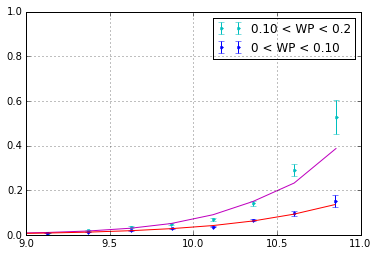

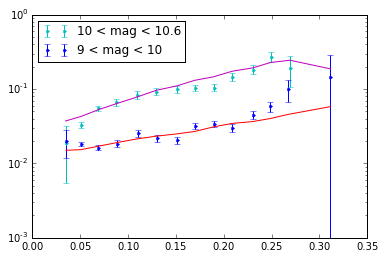

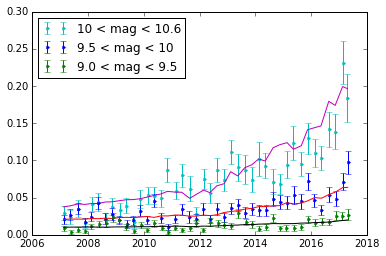

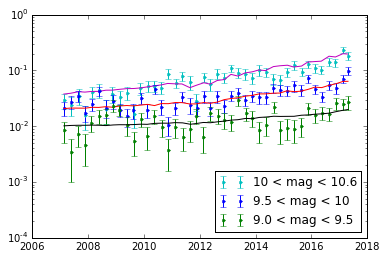

In [17]:
plot_fit_all(fit)

### Color != 1.5 fit

In [18]:
print('Hang tight, this could take a few minutes')
# fit = fit_sota_model(data_all['color'] == 1.5, ms_disabled=True)
mask = data_all['color'] != 1.5
fit = fit_sota_model(mask, ms_disabled=True)

Hang tight, this could take a few minutes
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 17055.6
Final fit statistic   = 16200.2 at function evaluation 1392
Data points           = 103285
Degrees of freedom    = 103278
Change in statistic   = 855.464
   model.scl0     4.05385     
   model.scl1     5.12644     
   model.scl2     1.71893     
   model.off0     -2.23367    
   model.off1     0.418999    
   model.off2     0.115079    
   model.p_bright_fail   0.00389742  


INFO:sherpa.ui.utils:Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 17055.6
Final fit statistic   = 16200.2 at function evaluation 1392
Data points           = 103285
Degrees of freedom    = 103278
Change in statistic   = 855.464
   model.scl0     4.05385     
   model.scl1     5.12644     
   model.scl2     1.71893     
   model.off0     -2.23367    
   model.off1     0.418999    
   model.off2     0.115079    
   model.p_bright_fail   0.00389742  


datasets       = (1,)
itermethodname = none
methodname     = neldermead
statname       = cash
succeeded      = True
parnames       = ('model.scl0', 'model.scl1', 'model.scl2', 'model.off0', 'model.off1', 'model.off2', 'model.p_bright_fail')
parvals        = (4.0538501953116741, 5.1264366287835923, 1.7189285794461362, -2.2336697695626575, 0.41899916884144967, 0.11507943243652813, 0.0038974199036680645)
statval        = 16200.1824922
istatval       = 17055.6469371
dstatval       = 855.46444487
numpoints      = 103285
dof            = 103278
qval           = None
rstat          = None
message        = Optimization terminated successfully
nfev           = 1392
[4.0538501953116741, 5.1264366287835923, 1.7189285794461362, -2.2336697695626575, 0.41899916884144967, 0.11507943243652813, 0.0038974199036680645]


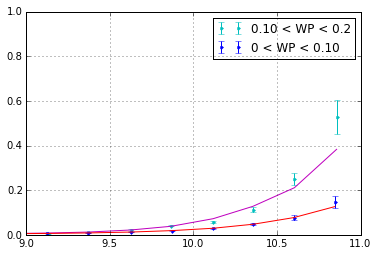

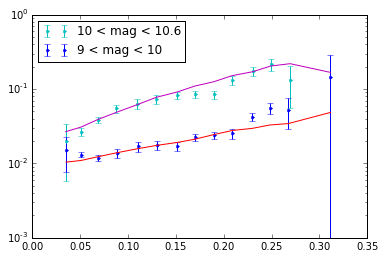

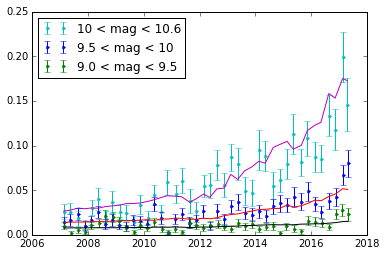

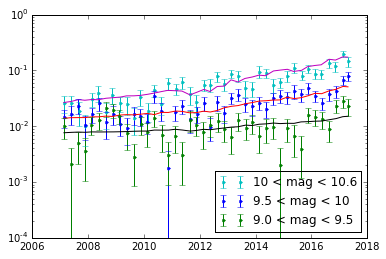

In [19]:
plot_fit_all(fit, mask=mask)

### Color == 1.5 fit

In [20]:
print('Hang tight, this could take a few minutes')
mask = data_all['color'] == 1.5
fit = fit_sota_model(mask, ms_disabled=True)

Hang tight, this could take a few minutes
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 6121.6
Final fit statistic   = 5274.4 at function evaluation 1750
Data points           = 22562
Degrees of freedom    = 22555
Change in statistic   = 847.199
   model.scl0     4.41115     
   model.scl1     6.91647     
   model.scl2     4.38254     
   model.off0     -1.46634    
   model.off1     0.604651    
   model.off2     -0.389908   
   model.p_bright_fail   0.00179187  


INFO:sherpa.ui.utils:Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 6121.6
Final fit statistic   = 5274.4 at function evaluation 1750
Data points           = 22562
Degrees of freedom    = 22555
Change in statistic   = 847.199
   model.scl0     4.41115     
   model.scl1     6.91647     
   model.scl2     4.38254     
   model.off0     -1.46634    
   model.off1     0.604651    
   model.off2     -0.389908   
   model.p_bright_fail   0.00179187  


datasets       = (1,)
itermethodname = none
methodname     = neldermead
statname       = cash
succeeded      = True
parnames       = ('model.scl0', 'model.scl1', 'model.scl2', 'model.off0', 'model.off1', 'model.off2', 'model.p_bright_fail')
parvals        = (4.411152936402706, 6.9164655965293083, 4.3825409576699306, -1.4663437225896943, 0.60465093328488229, -0.38990790420590932, 0.0017918677401650661)
statval        = 5274.40491679
istatval       = 6121.60425574
dstatval       = 847.199338951
numpoints      = 22562
dof            = 22555
qval           = None
rstat          = None
message        = Optimization terminated successfully
nfev           = 1750
[4.411152936402706, 6.9164655965293083, 4.3825409576699306, -1.4663437225896943, 0.60465093328488229, -0.38990790420590932, 0.0017918677401650661]


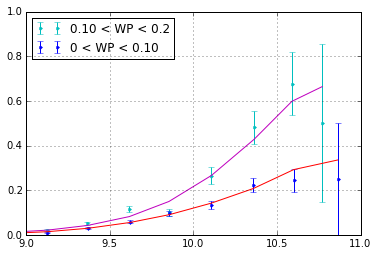

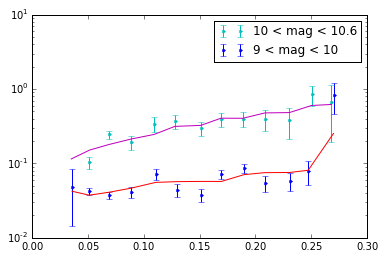

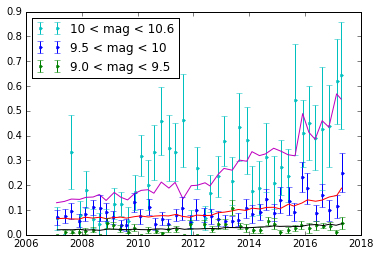

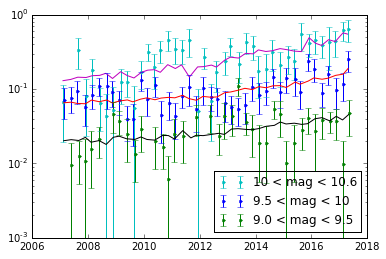

In [21]:
plot_fit_all(fit, mask=mask)

## Compare 2017 to 2015 coefficients

### Failure prob vs. mag for Wp=(0.1, 0.2, 0.3)


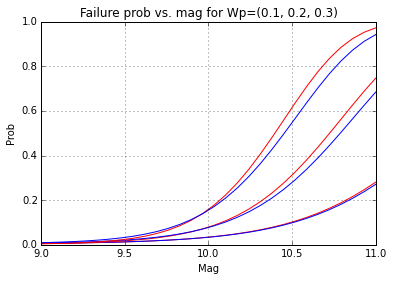

In [22]:
mag = np.linspace(9, 11, 30)
for wp in (0.1, 0.2, 0.3):
    plt.plot(mag, p_fail(SOTA2015_FIT_NO_1P5, mag-10, wp), 'r')
    plt.plot(mag, p_fail(SOTA2017_FIT_NO_1P5, mag-10, wp), 'b')

plt.grid()
plt.xlabel('Mag')
plt.ylim(0, 1)
plt.title('Failure prob vs. mag for Wp=(0.1, 0.2, 0.3)')
plt.ylabel('Prob');

### Failure prob vs. Wp for mag=(10.0, 10.25, 10.5)

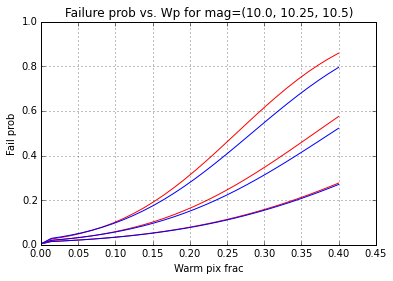

In [23]:
for mag in (10.0, 10.25, 10.5):
    wp = np.linspace(0, 0.4, 30)
    plt.plot(wp, p_fail(SOTA2015_FIT_NO_1P5, mag-10, wp), 'r')
    plt.plot(wp, p_fail(SOTA2017_FIT_NO_1P5, mag-10, wp), 'b')

plt.grid()
plt.xlabel('Warm pix frac')
plt.ylim(0, 1)
plt.title('Failure prob vs. Wp for mag=(10.0, 10.25, 10.5)')
plt.ylabel('Fail prob');

### Histogram of warm pixel fraction

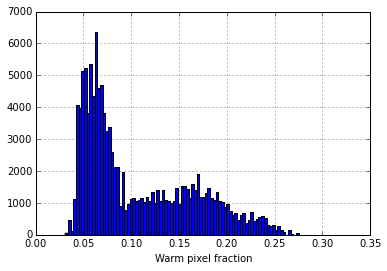

In [27]:
plt.hist(data_all['warm_pix'], bins=100)
plt.grid()
plt.xlabel('Warm pixel fraction');